# Set connection with GitHub

In [1]:
# ! cd /kaggle/working && rm -rf RECsys_Challenge2024

In [2]:
from kaggle_secrets import UserSecretsClient

token = UserSecretsClient().get_secret("Token")

! git clone https://{token}@github.com/madratak/RECsys_Challenge2024.git

Cloning into 'RECsys_Challenge2024'...
remote: Enumerating objects: 5099, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 5099 (delta 85), reused 103 (delta 40), pack-reused 4928 (from 3)
Receiving objects: 100% (5099/5099), 379.22 MiB | 36.16 MiB/s, done.
Resolving deltas: 100% (2934/2934), done.
Updating files: 100% (422/422), done.


In [3]:
! pip install PyGithub requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 27.3 MB/s eta 0:00:00


In [4]:
! pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.6 MB/s eta 0:00:00


In [5]:
%cd /kaggle/working/RECsys_Challenge2024
! python run_compile_all_cython.py

/kaggle/working/RECsys_Challenge2024
run_compile_all_cython: Found 11 Cython files in 5 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/usr/bin/python3'
Compiling [1/11]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1252:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   17 | #warning "Using deprecated NumPy API, disabl

In [6]:
from Utils.notebookFunctions import *
from Utils.xgboost_functions import *
import numpy as np
import pandas as pd
import scipy.sparse as sps
import time
import shutil
import optuna
import json
import os
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit
from tqdm import tqdm
from xgboost import XGBRanker

%matplotlib inline
from xgboost import plot_importance

K_PATH = '/kaggle/working/RECsys_Challenge2024'
GH_PATH = 'TrainedModels/WithoutKFCV'
D_PATH = 'XGBoost'

np.random.seed(42)

In [7]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.MatrixFactorization.FasterIALSRecommender import FasterIALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import ScaledPureSVDRecommender
from Recommenders.Neural.MultVAE_PyTorch_Recommender import MultVAERecommender_PyTorch_OptimizerMask 
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python

## Import the repository

In [8]:
repo = get_repo_from_github(token)

Repository 'RECsys_Challenge2024' found.


In [9]:
config = {
    'model': 'SimpleXGBoostNoCont',
    'metric': 'MAP',
    'categorical': True,
    'contents': False,
    'tune_parameters': False,
    'database_path': '/kaggle/working/history_SimpleXGBoostNoCont_MAP.db',
    'copy_prev_best_params': False,
    'tune_best_params': True,
    'save_github': True
}

Import the database where previous tuning trials have been saved.

In [10]:
try:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Construction of URM and ICM matrices

In [11]:
URM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv")

n_users = len(URM_all_dataframe["user_id"].unique())
n_items = len(URM_all_dataframe["item_id"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)),
                        shape = (n_users, n_items))

URM_all

<35736x38121 sparse matrix of type '<class 'numpy.float64'>'
	with 1764607 stored elements in Compressed Sparse Row format>

In [12]:
ICM_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv")

n_items = len(ICM_dataframe["item_id"].unique())
n_features = len(ICM_dataframe["feature_id"].unique())

ICM_all = sps.csr_matrix((ICM_dataframe["data"].values, 
                          (ICM_dataframe["item_id"].values, ICM_dataframe["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all

<38121x94331 sparse matrix of type '<class 'numpy.float64'>'
	with 2940040 stored elements in Compressed Sparse Row format>

# Training
Split the dataset in train, validation and test set.

In [13]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 141 ( 0.4%) Users that have less than 1 test interactions


## Candidate Generators

Import the best previously trained recommenders to use them as candidate generators.

In [14]:
cg_recommenders = {
    "RP3beta": RP3betaRecommender,
    "ItemKNNCF": ItemKNNCFRecommender,
    "SLIMElasticNet": SLIMElasticNetRecommender
}

if config["tune_parameters"]:
    print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
    candidate_generator_recommenders = fit_recommenders("Recall", "Train", URM_train, ICM_all, cg_recommenders, GH_PATH, "cg", repo)

## Features
Import the other previously trained recommenders to use them as features.

In [15]:
f_recommenders = {
    "RP3beta": RP3betaRecommender,
    # "P3alpha": P3alphaRecommender,
    "ItemKNNCF": ItemKNNCFRecommender,
    "ItemKNNCBF": ItemKNNCBFRecommender,
    # "UserKNNCF": UserKNNCFRecommender,
    "FasterIALS": FasterIALSRecommender,
    # "NMF": NMFRecommender,
    "PureSVDItem": PureSVDItemRecommender,
    # "ScaledPureSVD": ScaledPureSVDRecommender,
    "MultVAE": MultVAERecommender_PyTorch_OptimizerMask,
    "SLIMElasticNet": SLIMElasticNetRecommender,
    # "SLIM_BPR": SLIM_BPR_Python,
}

if config["tune_parameters"]:
    print("***TRAINING FEATURE RECOMMENDERS***\n")
    features_recommenders = fit_recommenders("MAP", "Train", URM_train, ICM_all, f_recommenders, GH_PATH, "f", repo)

## Training dataframe building
Build the dataframe with the predictions, the popularity of the item, the user activity, the profile length and item features.

Then, set features and target to use for the training.

In [16]:
if config["tune_parameters"]:
    training_dataframe, groups_train = create_XGBoost_dataframe(URM_train, candidate_generator_recommenders, features_recommenders, ICM_all, URM_validation, cutoff=50, categorical=config["categorical"], contents=config["contents"])
    display(training_dataframe)
    print("-" * 40)
    display(groups_train)

    del candidate_generator_recommenders
    del features_recommenders

    # Extract labels and features
    y_train = training_dataframe["Label"]
    X_train = training_dataframe.drop(columns=["Label"])

## XGBoost training
Let's train XGBoost to rerank those prediction using as lable whether they should be recommended or not.

In [17]:
from Recommenders.XGBoost.XGBoostRankerRecommender import XGBoostRankerRecommender

def objective_function_XGBoostRanker(optuna_trial):
    
    recommender_instance = XGBoostRankerRecommender(URM_train, training_dataframe)

    full_hyperp = {
            "n_estimators": optuna_trial.suggest_int("n_estimators", 50, 500),
            "learning_rate": optuna_trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            "reg_alpha": optuna_trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
            "reg_lambda": optuna_trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
            "max_depth": optuna_trial.suggest_int("max_depth", 3, 12),
            "max_leaves": optuna_trial.suggest_int("max_leaves", 2, 256),
            "grow_policy": optuna_trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "booster": optuna_trial.suggest_categorical("booster", ["gbtree", "dart"]),
            # "tree_method": optuna_trial.suggest_categorical("tree_method", ["hist", "gpu_hist", "approx"]),
            "tree_method": "hist",
            "objective": optuna_trial.suggest_categorical("objective", ["map", "pairwise", "ndcg"])
        }

    recommender_instance.fit(
        X_train,
        y_train,
        groups_train,
        **full_hyperp
    )

    result_df, _ = evaluator_test.evaluateRecommender(recommender_instance)
    
    return result_df.loc[10]["MAP"]

In [18]:
if config['tune_parameters']:
    
    optuna_study = optuna.create_study(direction='maximize', study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)

    optuna_study.optimize(objective_function_XGBoostRanker, n_trials=10)

### Some optuna visualizations on recommender parameters

In [19]:
if not config['tune_parameters']:
    optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
fig = optuna.visualization.plot_slice(optuna_study)
fig.show()

In [20]:
if not config['tune_parameters']:
    optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
fig = optuna.visualization.plot_param_importances(optuna_study)
fig.show()

# Testing
Let's train the recommender with best parameter values: both candidate generator and feature one.
Then create the new dataframe.

In [21]:
if config['tune_best_params']:

    print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
    candidate_generator_recommenders = fit_recommenders("Recall", "TrainVal", URM_train + URM_validation, ICM_all, cg_recommenders, GH_PATH, "cg", repo)

    print("***TRAINING FEATURE RECOMMENDERS***\n")
    features_recommenders = fit_recommenders("MAP", "TrainVal", URM_train + URM_validation, ICM_all, f_recommenders, GH_PATH, "f", repo)

    train_val_dataframe, groups_train_val = create_XGBoost_dataframe(URM_train + URM_validation, candidate_generator_recommenders, features_recommenders, ICM_all, URM_test, cutoff=50, categorical=config["categorical"], contents=config["contents"])

    del candidate_generator_recommenders
    del features_recommenders

    display(train_val_dataframe)
    
    # Extract labels and features
    y_train_val = train_val_dataframe["Label"]
    X_train_val = train_val_dataframe.drop(columns=["Label"])

***TRAINING CONTENT GENERATION RECOMMENDERS***

RP3beta Model - TRAINING with its best parameters.
RP3betaRecommender: Similarity column 38121 (100.0%), 1751.35 column/sec. Elapsed time 21.77 sec
Training of RP3beta completed in 25.18 sec.

ItemKNNCF Model - TRAINING with its best parameters.
Similarity column 38121 (100.0%), 2653.36 column/sec. Elapsed time 14.37 sec
Training of ItemKNNCF completed in 14.87 sec.

SLIMElasticNet Model - TRAINING with its best parameters.
Model for SLIMElasticNet already exists. Loading the saved model.
SLIMElasticNetRecommender: Loading model from file 'TrainedModels/WithoutKFCV/XGBoost/CandidateGenerator/TrainValbest_SLIMElasticNet_Recall_TrainVal_tuned'
SLIMElasticNetRecommender: Loading complete
***TRAINING FEATURE RECOMMENDERS***

RP3beta Model - TRAINING with its best parameters.
RP3betaRecommender: Similarity column 38121 (100.0%), 1995.93 column/sec. Elapsed time 19.10 sec
Training of RP3beta completed in 20.33 sec.

ItemKNNCF Model - TRAINING w

  0%|          | 0/35736 [00:00<?, ?it/s]/kaggle/working/RECsys_Challenge2024/Recommenders/Neural/MultVAE_PyTorch_Recommender.py:188: UserWarning:

Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)

100%|██████████| 35736/35736 [27:48<00:00, 21.42it/s]


,UserID,ItemID,Label,RP3beta,ItemKNNCF,ItemKNNCBF,FasterIALS,PureSVDItem,MultVAE,SLIMElasticNet,item_popularity,user_profile_len
0,0,51.0,False,0.215024,0.903856,0.000000,0.192419,0.043012,5.770544,0.196252,130,95
1,0,11966.0,False,0.201938,2.823273,0.000000,0.754257,0.156377,10.304276,0.147537,39,95
2,0,11875.0,False,0.062943,0.737080,0.000000,0.528419,0.079752,8.908233,0.058803,25,95
3,0,9911.0,False,0.053466,1.294928,0.000000,0.686548,0.073656,10.691162,0.090868,20,95
4,0,9316.0,False,0.070576,0.000000,0.000000,0.270280,0.042631,8.507269,0.043835,30,95
...,...,...,...,...,...,...,...,...,...,...,...,...
2878785,35735,35713.0,False,0.159385,1.153576,0.000000,0.681071,0.097949,7.235845,0.157077,31,26
2878786,35735,35712.0,False,0.055760,2.999887,0.098820,0.638844,0.115371,7.426314,0.165201,21,26
2878787,35735,35660.0,False,0.107449,2.679675,0.000000,0.685326,0.086949,8.342996,0.181524,23,26
2878788,35735,36032.0,False,0.000000,0.000000,0.000000,0.511405,0.061282,6.000887,0.000000,16,26


### Train best XGBoost model

In [22]:
if config['tune_best_params']:

    if config['tune_parameters']:
        best_params = optuna_study.best_trial.params
    else: 
        with open(f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 'r') as best_params_json:
            best_params = json.load(best_params_json)

    recommender_instance = XGBoostRankerRecommender(URM_train + URM_validation, train_val_dataframe)
    recommender_instance.fit(
        X_train_val,
        y_train_val,
        groups_train_val,
        **best_params
    )

## Feature importance

<Axes: title={'center': 'Gain'}, xlabel='F score', ylabel='Features'>

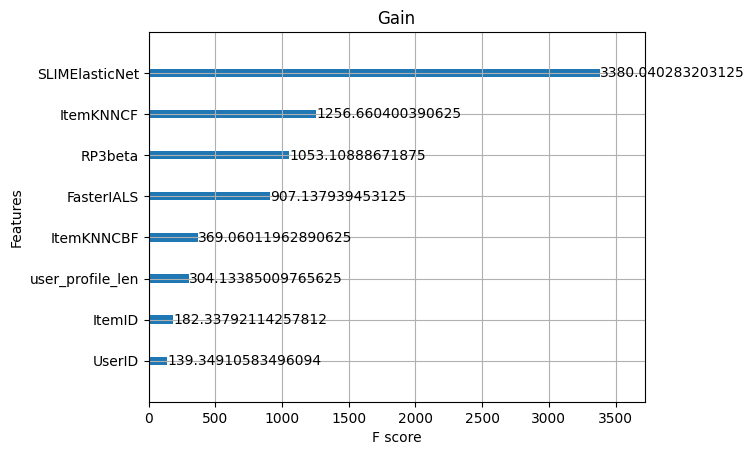

In [23]:
plot_importance(recommender_instance.model, importance_type='gain', title='Gain')

<Axes: title={'center': 'Cover'}, xlabel='F score', ylabel='Features'>

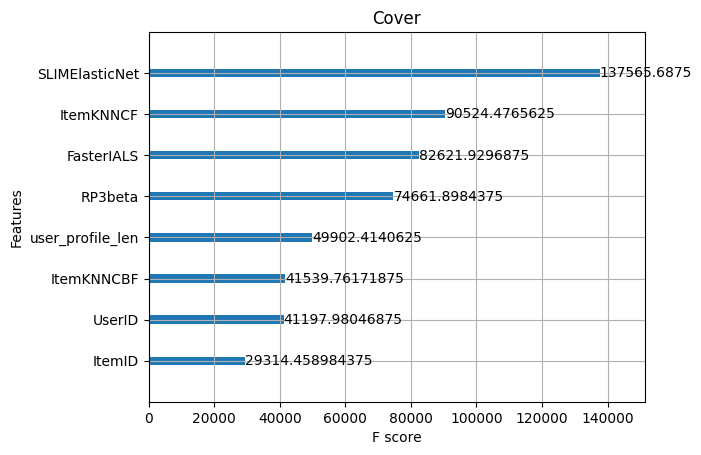

In [24]:
plot_importance(recommender_instance.model, importance_type='cover', title='Cover')

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

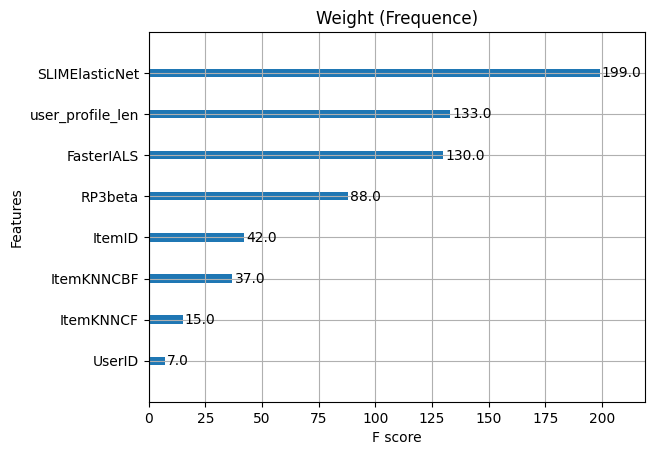

In [25]:
plot_importance(recommender_instance.model, importance_type='weight', title='Weight (Frequence)')

# Submission
Train the candidate generator and feature generators with URM_all.

In [26]:
if config['tune_best_params']:

    print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
    candidate_generator_recommenders = fit_recommenders("Recall", "TrainValTest", URM_all, ICM_all, cg_recommenders, GH_PATH, "cg", repo)
    
    print("***TRAINING FEATURE RECOMMENDERS***\n")
    features_recommenders = fit_recommenders("MAP", "TrainValTest", URM_all, ICM_all, f_recommenders, GH_PATH, "f", repo)

    all_dataframe, all_groups = create_XGBoost_dataframe(URM_all, candidate_generator_recommenders, features_recommenders, ICM_all, cutoff=50, categorical=config["categorical"], contents=config["contents"])

    del candidate_generator_recommenders
    del features_recommenders
    
    recommender_instance.set_recommendations_dataframe(all_dataframe)

***TRAINING CONTENT GENERATION RECOMMENDERS***

RP3beta Model - TRAINING with its best parameters.
RP3betaRecommender: Similarity column 38121 (100.0%), 1572.01 column/sec. Elapsed time 24.25 sec
Training of RP3beta completed in 27.45 sec.

ItemKNNCF Model - TRAINING with its best parameters.
Similarity column 38121 (100.0%), 2391.74 column/sec. Elapsed time 15.94 sec
Training of ItemKNNCF completed in 16.56 sec.

SLIMElasticNet Model - TRAINING with its best parameters.
Model for SLIMElasticNet already exists. Loading the saved model.
SLIMElasticNetRecommender: Loading model from file 'TrainedModels/WithoutKFCV/XGBoost/CandidateGenerator/TrainValTestbest_SLIMElasticNet_Recall_TrainValTest_tuned'
SLIMElasticNetRecommender: Loading complete
***TRAINING FEATURE RECOMMENDERS***

RP3beta Model - TRAINING with its best parameters.
RP3betaRecommender: Similarity column 38121 (100.0%), 1772.92 column/sec. Elapsed time 21.50 sec
Training of RP3beta completed in 22.84 sec.

ItemKNNCF Model - TR

100%|██████████| 35736/35736 [27:49<00:00, 21.40it/s]


Create the recommendations for the submission.

In [27]:
if config['tune_best_params']:

    data_target_users_test = pd.read_csv('/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv')
    create_submission(data_target_users_test, recommender_instance, f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv')

Submission file saved as /kaggle/working/submission_SimpleXGBoostNoCont_MAP.csv


# Save Version on GitHub 

Write or import a json file where best hyperparameters are saved. 

In [28]:
if config['tune_parameters']:
    with open(f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 'w') as params_file:
        json.dump(optuna_study.best_params, params_file)
        
    if config['save_github']:
        upload_file(
            f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{config["model"]}_{config["metric"]} tuning results (from kaggle notebook)',
            repo
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/'\
        f'best_params_{config["model"]}_{config["metric"]}.json', 
        f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json'
    )

Save the history of the tuned model.

In [29]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'], 
        f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db',
        f'Tuning {config["model"]}_{config["metric"]} db updated results (from kaggle notebook)',
        repo
    )

Save the best trained model and its submission.

In [30]:
if config['save_github'] and config['tune_best_params']: 
    upload_file(
                f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv', 
                f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/Submission/submission_{config["model"]}_{config["metric"]}.csv', 
                f'New {config["model"]}_{config["metric"]} submission (from kaggle notebook)',
                repo
            )

File 'TrainedModels/WithoutKFCV/XGBoost/SimpleXGBoostNoContRecommender/OptimizingMAP/Submission/submission_SimpleXGBoostNoCont_MAP.csv' created successfully.
